In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7268749691082327432
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2239889408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11381055852368422095
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers

import numpy as np
from matplotlib import pyplot

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_teset = X_test.astype('float32')

(X_train, X_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('X_train : ', X_train.shape)
print('X_valid : ', X_valid.shape)
print('X_test : ', X_test.shape)

X_train :  (45000, 32, 32, 3)
X_valid :  (5000, 32, 32, 3)
X_test :  (10000, 32, 32, 3)


In [7]:
mean = np.mean(X_train, axis=(0,1,2,3))
std=np.std(X_train, axis=(0,1,2,3))

offset= 1e-7
X_train = (X_train-mean)/(std+offset)
X_valid = (X_valid-mean)/(std+offset)
X_test = (X_test-mean)/(std+offset)

y_train = np_utils.to_categorical(y_train, num_classes=10)
y_valid = np_utils.to_categorical(y_valid, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

In [8]:
data_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)

data_gen.fit(X_train)

In [10]:
base_hidden_units=32
weight_decay=1e-4

model=Sequential()

# Conv1
model.add(Conv2D(base_hidden_units, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv2
model.add(Conv2D(base_hidden_units, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Conv3
model.add(Conv2D(base_hidden_units * 2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv4
model.add(Conv2D(base_hidden_units * 2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Conv5
model.add(Conv2D(base_hidden_units * 4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv6
model.add(Conv2D(base_hidden_units * 4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# FC7
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

In [13]:
batch_size=128
epochs=125

checkpointer= ModelCheckpoint(filepath='mini_vggnet.125epochs.hdf5', verbose=1, save_best_only=True)
adam_optimizer = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size), callbacks=[checkpointer],\
    steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs, verbose=2, validation_data=(X_valid, y_valid))

Epoch 1/125


C:\Users\777\AppData\Local\Temp\ipykernel_1108\3629338417.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size), callbacks=[checkpointer],\



Epoch 1: val_loss improved from inf to 1.99403, saving model to mini_vggnet.125epochs.hdf5
351/351 - 20s - loss: 2.3325 - accuracy: 0.3076 - val_loss: 1.9940 - val_accuracy: 0.3130 - 20s/epoch - 56ms/step
Epoch 2/125

Epoch 2: val_loss improved from 1.99403 to 1.42576, saving model to mini_vggnet.125epochs.hdf5
351/351 - 18s - loss: 1.8044 - accuracy: 0.4038 - val_loss: 1.4258 - val_accuracy: 0.5030 - 18s/epoch - 50ms/step
Epoch 3/125

Epoch 3: val_loss improved from 1.42576 to 1.33138, saving model to mini_vggnet.125epochs.hdf5
351/351 - 17s - loss: 1.6332 - accuracy: 0.4489 - val_loss: 1.3314 - val_accuracy: 0.5328 - 17s/epoch - 50ms/step
Epoch 4/125

Epoch 4: val_loss did not improve from 1.33138
351/351 - 17s - loss: 1.5310 - accuracy: 0.4800 - val_loss: 1.3701 - val_accuracy: 0.5282 - 17s/epoch - 48ms/step
Epoch 5/125

Epoch 5: val_loss did not improve from 1.33138
351/351 - 17s - loss: 1.4470 - accuracy: 0.5047 - val_loss: 1.3908 - val_accuracy: 0.5346 - 17s/epoch - 49ms/step
Ep

In [14]:
scores = model.evaluate(X_test, y_test, batch_size = batch_size, verbose=1)

79/79 [==============================] - 1s 8ms/step - loss: 0.5065 - accuracy: 0.8518


In [15]:
print("Test result : %.3f loss: %.3f"%(scores[1], scores[0]))

Test result : 0.852 loss: 0.507


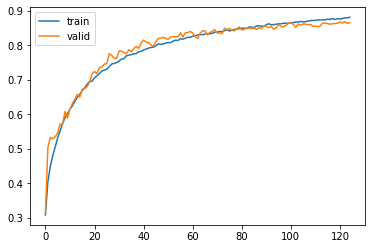

In [20]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='valid')
pyplot.legend()
pyplot.show()